$\Delta u + k^2(1+q) u = f $ in $\Omega = [0,1]^2$    
$u = 0 $ on $\partial \Omega$

In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import time

In [2]:
k = 1   # wavenumber
N = 100 # 格点数
h = 1/N # 间隔

In [3]:
def q_gen_example(N):
    q = np.zeros((N+1,N+1))
    q_value = 0.1
    x1,x2,x3,y1,y2,y3,y4 = 0.2,0.4,0.7,0.2,0.3,0.6,0.7
    q[int(x1*N):int(x2*N),int(y1*N):int(y4*N)] = q_value
    q[int(x2*N):int(x3*N),int(y2*N):int(y3*N)] = q_value
    return q
def q_generation(N,method = 1):
    if method == 1:
        return q_gen_example(N)
    print('method error')
q = q_generation(N)

<AxesSubplot:>

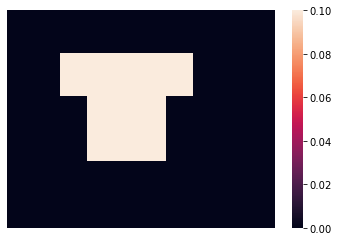

In [4]:
sns.heatmap(q, xticklabels=False, yticklabels=False)

$u = \sin(x\pi)\sin^2(y\pi)$  
$f = \Delta u + (1+q) u = (1+q-2\pi^2)u$  
$=(1+q-\pi^2)u+2\pi^2 cos(2\pi y)sin(x\pi)$

In [5]:
def u_gen(N):
    u = np.zeros((N+1,N+1))
    for i in range(1,N):
        for j in range(1,N):
            u[i,j] = np.sin(i*np.pi/N)*np.sin(j*np.pi/N)
    return u

u_truth = u_gen(N)

<AxesSubplot:>

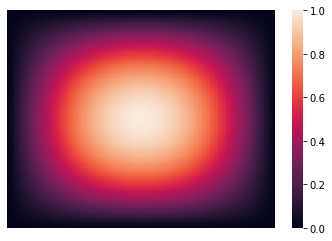

In [6]:
sns.heatmap(u_truth, xticklabels=False, yticklabels=False)

In [7]:
def f_gen_1(N,q,u):
    f = np.zeros((N+1,N+1))
    f[1:-1,1:-1] = (1+q[1:-1,1:-1]-2*np.pi*np.pi)*u[1:-1,1:-1]
    return f

# def f_gen_2(N,q):
#     f = np.zeros((N+1,N+1))
#     for i in range(1,N):
#         for j in range(1,N):
#             f[i,j] = (1+q[i,j] - 5*np.pi*np.pi)*np.sin(i*np.pi/N)*np.sin(j*np.pi/N)*np.sin(j*np.pi/N)+2*np.pi*np.pi*np.sin(i*np.pi/N)
#     return f
f = f_gen_1(N,q,u_truth)

<AxesSubplot:>

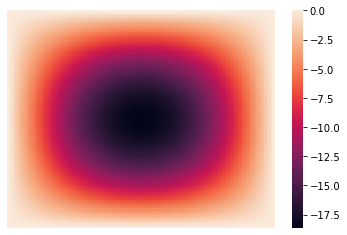

In [8]:
sns.heatmap(f, xticklabels=False, yticklabels=False)

## 五点格式
$A \,u_{i,j} = u_{i+1,j} +u_{i-1,j} +u_{i,j+1} +u_{i,j-1}  $  
$\frac{A-4I}{h^2} u_{i,j} + k^2(1+q_{i,j})u_{i,j} = f_{i,j} $ 
### Method1
$u_{i,j}^{n+1} = \frac{1}{4}[Au_{i,j}^n +k^2 h^2(1+q_{i,j})u_{i,j}^n - h^2 f_{i,j}]$
### Method2
$u_{i,j}^{n+1} = [Au_{i,j}^n - h^2 f_{i,j}]/[4-k^2 h^2(1+q_{i,j})]$  

In [9]:
def Error(a,a_truth,gap = 1e-10):
    a1 = np.where(a<gap,gap,a)
    a_t1 = np.where(a_truth < gap, gap, a_truth)
    return np.abs(a1/a_t1 - 1)


def A(v):
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0
    return v[1:-1,2:] + v[:-2,1:-1]+ v[2:,1:-1]+v[1:-1,:-2]

In [10]:
def Method_1(q,f,N,u_truth,nt = 100,u_in = np.zeros((N + 1, N + 1)),k = 1):
    h = 1/N
    u = u_in
    
    
    for it in range(nt):
        uu = u.copy()
        u[1:-1, 1:-1] = (A(uu) + h * h*k *k*
            (1 + q[1:-1, 1:-1]) * uu[1:-1, 1:-1] - h * h * f[1:-1,1:-1]) / 4
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
    
    err = Error(u,u_truth)
    err1 = np.linalg.norm(err,ord = 2)/(N-1)
    err2 = np.abs(err).max()
    
    return u,err1,err2

def Method_2(q,f,N,u_truth,nt = 100,u_in = np.zeros((N + 1, N + 1))):
    h = 1/N
    u = u_in
    
    for it in range(nt):
        uu = u.copy()
        u[1:-1, 1:-1] = (A(uu) - h * h * f[1:-1,1:-1]) / (4-k*k*h*h*(1+q[1:-1,1:-1]))
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        
    err = Error(u,u_truth)
    err1 = np.linalg.norm(err,ord = 2)/(N-1)
    err2 = np.abs(err).max()
    return u,err1,err2

## 九点格式
$B \,u_{i,j} = u_{i+1,j+1} +u_{i-1,j-1} +u_{i-1,j+1} +u_{i+1,j-1}$  
$\frac{A-4I}{h^2} u_{i,j} + \frac{B - 2A+4I}{6h^2}u_{i,j} + k^2(1+q_{i,j})u_{i,j} + \frac{k^2}{12}(A-4I)
(1+q_{i,j})u_{i,j}= f_{i,j} + \frac{1}{12}(A-4I)f_{i,j}$
### Method3
$u_{i,j}^{n+1} = [(B+4A)u_{i,j}^{n} - h^2(\frac{A}{2} +4I)f_{i,j}]/[20 - k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$  
$M_1 = [h^2(\frac{A}{2} +4I)f_{i,j}], M_2 = [k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$  
### Method4
$u_{i,j}^{n+1} = [4Au_{i,j}^{n} - h^2(\frac{A}{2} +4I)f_{i,j}]/[20 - k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j}) - B(1)]$  
$M_1 = [h^2(\frac{A}{2} +4I)f_{i,j}], M_2 = [k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$
### Method41
$u_{i,j}^{n+1} = [h^2(\frac{A}{2} +4I)f_{i,j}]/[-20 + k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j}) + (4A+B)(1)]$  
$M_1 = [h^2(\frac{A}{2} +4I)f_{i,j}], M_2 = [k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$
### Method42
$u_{i,j}^{n+1} = [(B+4A+4I)u_{i,j}^{n} - h^2(\frac{A}{2} +4I)f_{i,j}]/[24 - k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$  
$M_1 = [h^2(\frac{A}{2} +4I)f_{i,j}], M_2 = [k^2 h^2 (\frac{A}{2} +4I)(1+q_{i,j})]$ 

In [11]:
def B(v):
    v[0, :] = 0
    v[-1, :] = 0
    v[:, 0] = 0
    v[:, -1] = 0
    return v[2:,2:] + v[:-2,2:]+ v[:-2,:-2]+v[2:,:-2]

In [12]:
def Method_3(q,f,N,u_truth,nt = 100,u_in = np.zeros((N + 1, N + 1)),k = 1):
    h = 1/N
    u = u_in


    M1 = h*h*(0.5*A(f)+4*f[1:-1,1:-1])
    M2 = h*h*k*k*(0.5*A(1+q)+4+4*q[1:-1,1:-1])
    
    for it in range(nt):
        uu = u.copy()
        u[1:-1, 1:-1] = (B(uu)+4*A(uu) - M1) / (20 - M2)
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0

        
    err = Error(u,u_truth)
    err1 = np.linalg.norm(err,ord = 2)/(N-1)
    err2 = np.abs(err).max()
    return u,err1,err2

def Method_4(q,f,N,u_truth,nt = 100,u_in = np.zeros((N + 1, N + 1)),k = 1):
    h = 1/N
    u = u_in

    
    M1 = h*h*(0.5*A(f)+4*f[1:-1,1:-1])
    M2 = h*h*k*k*(0.5*A(1+q)+4+4*q[1:-1,1:-1])
    
    for it in range(nt):
        uu = u.copy()
        u[1:-1, 1:-1] = (4*A(uu) - M1) / (20 - M2 - B(np.ones((N+1,N+1))))
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        
    err = Error(u,u_truth)
    err1 = np.linalg.norm(err,ord = 2)/(N-1)
    err2 = np.abs(err).max()
    return u,err1,err2

In [13]:
def perform(method,N,q,f,u_truth,test_list):
    u_list,u_error_1,u_error_2,time_l = [],[],[],[]
    times = test_list[0]
    u_in = np.zeros((N+1,N+1))
    if method == 1:
        time0 = time.time()
        for iter in test_list:
            tmp = Method_1(q,f,N,u_truth,times,u_in)
            u_list.append(tmp[0])
            u_error_1.append(tmp[1])
            u_error_2.append(tmp[2])
            time_l.append(time.time()-time0)
            u_in = tmp[0]
            times = iter
    elif method == 3:
        time0 = time.time()
        for iter in test_list:
            tmp = Method_3(q,f,N,u_truth,times,u_in)
            u_list.append(tmp[0])
            u_error_1.append(tmp[1])
            u_error_2.append(tmp[2])
            time_l.append(time.time()-time0)
            u_in = tmp[0]
            times = iter
    elif method == 4:
        time0 = time.time()
        for iter in test_list:
            tmp = Method_4(q,f,N,u_truth,times,u_in)
            u_list.append(tmp[0])
            u_error_1.append(tmp[1])
            u_error_2.append(tmp[2])
            time_l.append(time.time()-time0)
            u_in = tmp[0]
            times = iter
    else:
        print('method error')
        return 0 
    return u_list,u_error_1,u_error_2,time_l

In [14]:
def draw(N,draw_res = False,printf = False,testlist = [32,64,128,256,512,1024,2048,4096,8192,16384,32768]):
    q = q_generation(N)
    u_truth = u_gen(N)
    f = f_gen_1(N,q,u_truth)
    u1 = perform(1,N,q,f,u_truth,testlist)
    u3 = perform(3,N,q,f,u_truth,testlist)
    u4 = perform(4,N,q,f,u_truth,testlist)
    x_axis = np.log2(testlist)
    y11 = -np.log10(u1[1])
    y31 = -np.log10(u3[1])
    y41 = -np.log10(u4[1])
    y12 = -np.log10(u1[2])
    y32 = -np.log10(u3[2])
    y42 = -np.log10(u4[2])
    plt.plot(x_axis,y11,'s-',color = 'r',label="1-mean_err")
    plt.plot(x_axis,y31,'s-',color = 'g',label="3-mean_err")
    plt.plot(x_axis,y41,'s-',color = 'b',label="4-mean_err")
    plt.plot(x_axis,y12,'o-',color = 'r',label="1-max_err")
    plt.plot(x_axis,y32,'o-',color = 'g',label="3-max_err")
    plt.plot(x_axis,y42,'o-',color = 'b',label="4-max_err")
    plt.xlabel("iter:2^")#横坐标名字
    plt.ylabel("error:10^-")#纵坐标名字
    plt.legend(loc = "best")#图例
    plt.title('N = %d ' % N)
    plt.show()
    if draw_res == True:
        figure, ax = plt.subplots(1, 2, figsize=(12, 4))
        figure.tight_layout()
        ax[0].set_title("Method3")
        ax[1].set_title("Method4")
        plt.subplot(121)
        h1 = sns.heatmap(np.array(u3[0][-1]),
                         xticklabels=False,
                         yticklabels=False)
        plt.subplot(122)
        h2 = sns.heatmap(np.array(u4[0][-1]),
                         xticklabels=False,
                         yticklabels=False)
    if printf == True:
        print('方法1用时:\t')
        print(u1[3])
        print('方法3用时:\t')
        print(u3[3])
        print('方法4用时:\t')
        print(u4[3])

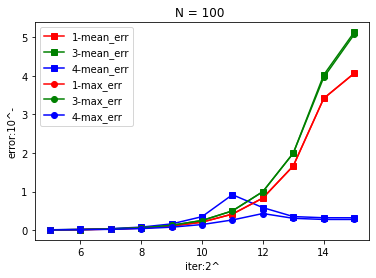

方法1用时:	
[0.0044002532958984375, 0.009183168411254883, 0.01770806312561035, 0.0345611572265625, 0.0650181770324707, 0.14407825469970703, 0.27305030822753906, 0.4995911121368408, 0.90702223777771, 1.7019851207733154, 3.511552095413208]
方法3用时:	
[0.004592180252075195, 0.009137868881225586, 0.01711583137512207, 0.031805992126464844, 0.060710906982421875, 0.11630010604858398, 0.22722101211547852, 0.4397718906402588, 0.8457529544830322, 1.633430004119873, 3.1893270015716553]
方法4用时:	
[0.004438877105712891, 0.008687734603881836, 0.016388654708862305, 0.030937671661376953, 0.05969405174255371, 0.11521792411804199, 0.22867774963378906, 0.44968390464782715, 0.8746926784515381, 1.7289519309997559, 3.467561960220337]


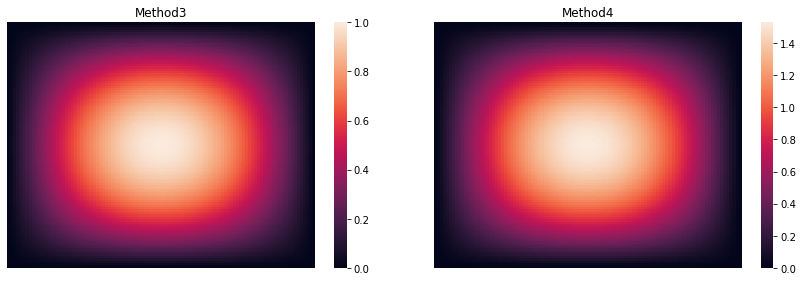

In [15]:
draw(100,True,True)

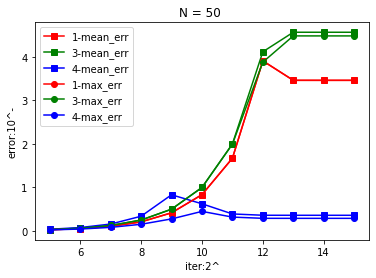

In [16]:
draw(50)

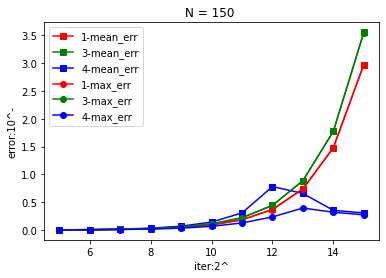

In [17]:
draw(150)